# Saliency Maps for Pfirrmann Grade Classification

Visualizes what the model focuses on for correct vs incorrect predictions.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "/home/mpuscian/Desktop/repozytoria/MINI_projects/Intervertebral-discs-degeneration-grade-classification-according-to-the-Pfirrmann-scale/3DCNN")

In [2]:
import numpy as np
import polars as pl
import SimpleITK as sitk
import torch
import matplotlib.pyplot as plt
from captum.attr import Saliency

from spine_utils import (
    PROJECT_PATH, DATA_PATH, DISC_MAP, DEVICE,
    load_model, get_t2_file_pairs, split_data_by_patient, extract_disc, predict
)

print(f"Device: {DEVICE}")

# Load model
model, ckpt = load_model()
print(f"Model loaded. Test acc: {ckpt.get('test_acc', 'N/A'):.1f}%")

/home/mpuscian/Envs/DeepLearning/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda
Model loaded. Test acc: 48.1%


In [3]:
files = get_t2_file_pairs()
_, _, test_files = split_data_by_patient(files)
gradings = pl.read_csv(DATA_PATH / "radiological_gradings.csv")
print(f"Test: {len(test_files)} scans")

Test: 32 scans


In [4]:
# Collect test samples
samples = []
for fp in test_files:
    scan, mask = sitk.ReadImage(str(fp["img"])), sitk.ReadImage(str(fp["msk"]))
    for row in gradings.filter(pl.col("Patient") == fp["pid"]).iter_rows(named=True):
        dl, tg = DISC_MAP.get(row["IVD label"]), row["Pfirrman grade"]
        if dl is None or tg is None: continue
        vol = extract_disc(scan, mask, dl)
        if vol is None: continue
        pg, probs = predict(model, vol)
        samples.append({"pid": fp["pid"], "dl": dl, "tg": tg, "pg": pg, 
                       "probs": probs, "err": abs(tg-pg), "vol": vol})
    del scan, mask
    torch.cuda.empty_cache()

correct = [s for s in samples if s["err"] == 0]
wrong = [s for s in samples if s["err"] >= 2]
print(f"Total: {len(samples)}, Correct: {len(correct)}, Wrong (err>=2): {len(wrong)}")

Total: 210, Correct: 100, Wrong (err>=2): 34


In [8]:
saliency_method = Saliency(model)

def get_saliency(vol):
    t = torch.from_numpy(vol).float().permute(2,0,1).unsqueeze(0).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        target = model(t).argmax(1).item()
    attr = saliency_method.attribute(t, target=target, abs=True)
    sal = attr.detach().cpu().numpy()[0,0]
    sal = np.transpose(sal, (1,2,0))
    torch.cuda.empty_cache()
    return (sal - sal.min()) / (sal.max() - sal.min() + 1e-8)

def show_saliency(sample, slices=[7,8,9]):
    vol, sal = sample["vol"], get_saliency(sample["vol"])
    fig, axes = plt.subplots(1, len(slices), figsize=(4*len(slices), 4))
    for i, s in enumerate(slices):
        axes[i].imshow(vol[:,:,s], cmap='gray')
        axes[i].imshow(sal[:,:,s], cmap='jet', alpha=0.5)
        axes[i].axis('off')
        axes[i].set_title(f"Slice {s}")
    status = "CORRECT" if sample["err"]==0 else f"WRONG (err={sample['err']})"
    fig.suptitle(f"Patient {sample['pid']}, Disc {sample['dl']}\nTrue: {sample['tg']}, Pred: {sample['pg']} [{status}]")
    plt.tight_layout()
    plt.show()

CORRECTLY CLASSIFIED EXAMPLES


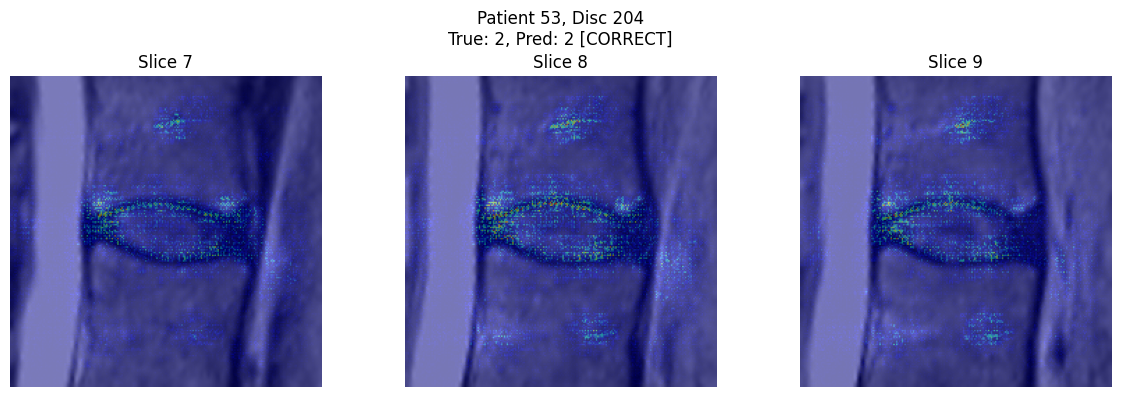

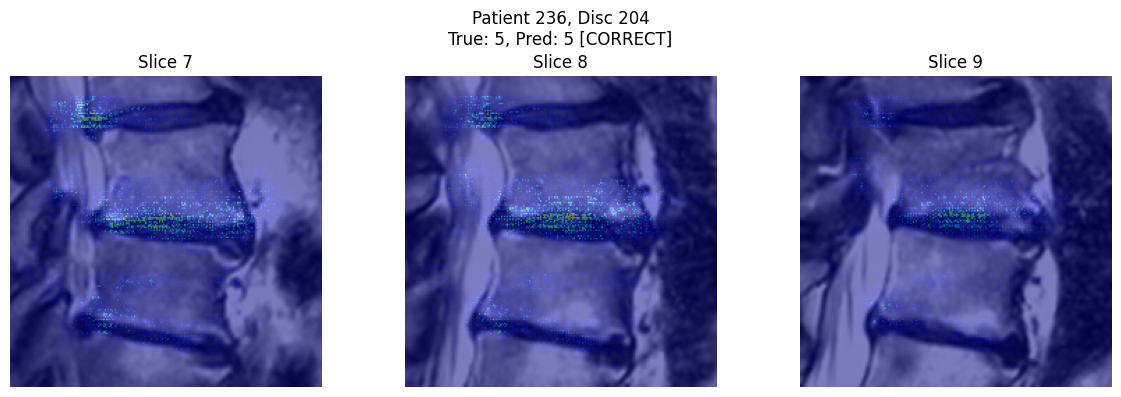

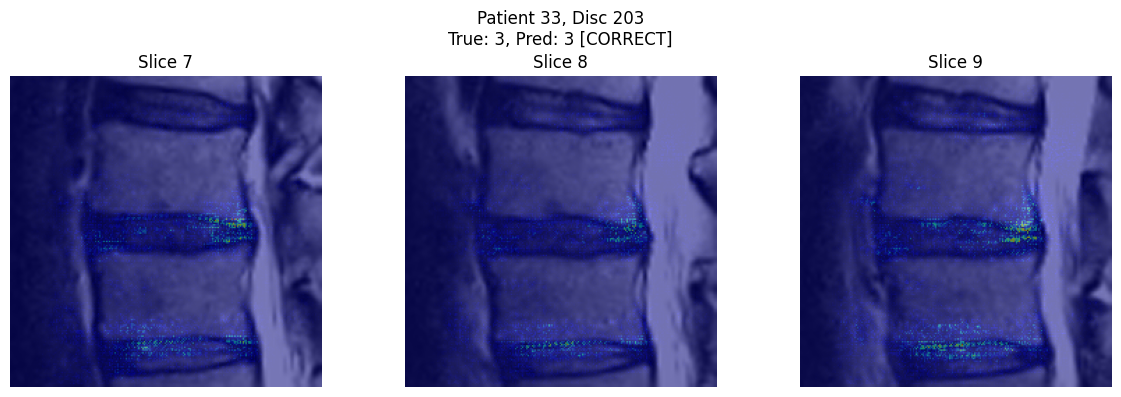

In [9]:
print("=" * 50)
print("CORRECTLY CLASSIFIED EXAMPLES")
print("=" * 50)
np.random.seed(42)
for s in np.random.choice(correct, min(3, len(correct)), replace=False):
    show_saliency(s)

INCORRECTLY CLASSIFIED (error >= 2)


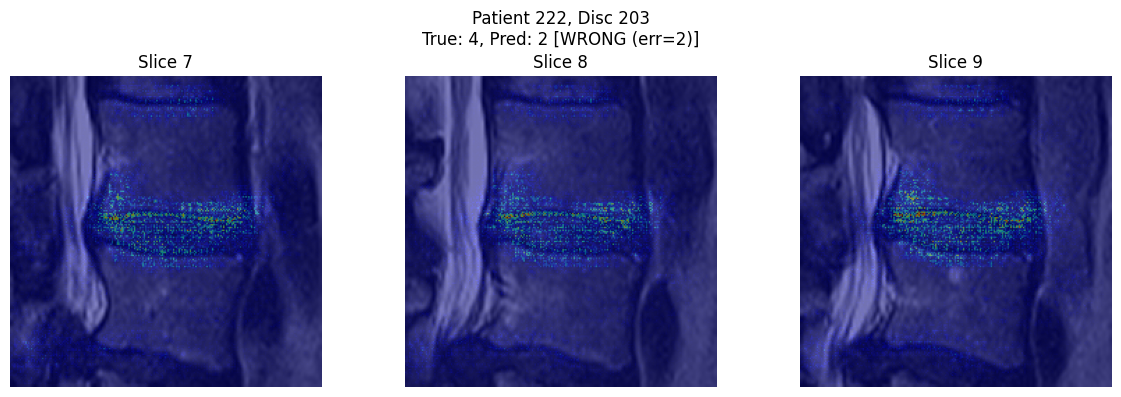

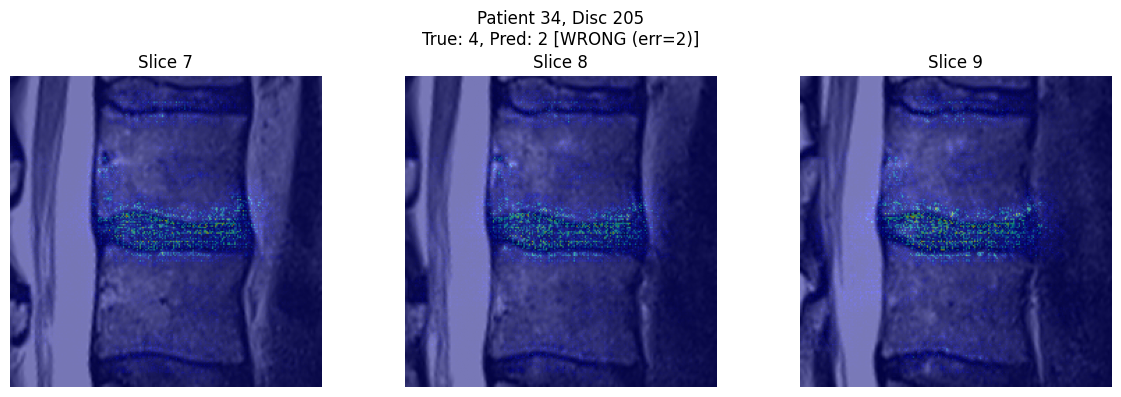

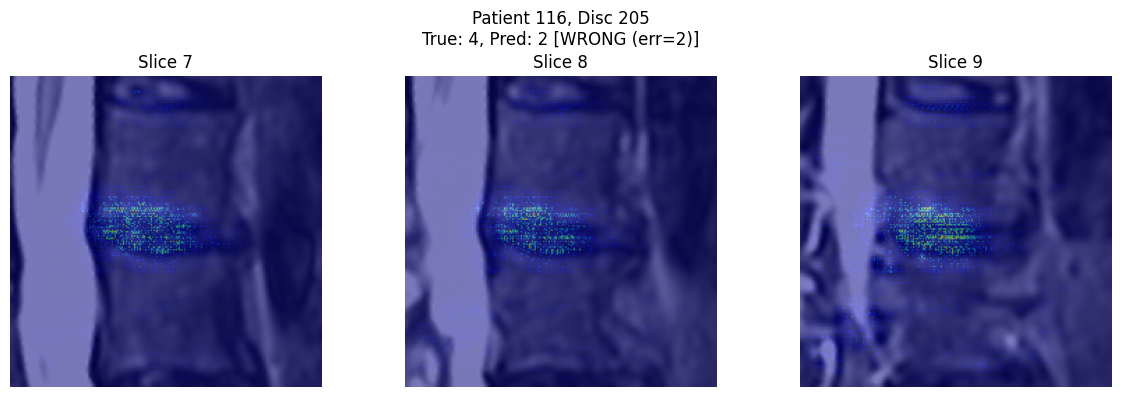

In [10]:
print("=" * 50)
print("INCORRECTLY CLASSIFIED (error >= 2)")
print("=" * 50)
for s in np.random.choice(wrong, min(3, len(wrong)), replace=False):
    show_saliency(s)